In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.svm import SVC 
from sklearn.preprocessing import LabelEncoder, Imputer, RobustScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_make_pipeline

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

# Set Style
sns.set(style = "whitegrid")

# To display all the columns
pd.options.display.max_columns = None

# To display all the rows
pd.options.display.max_rows = None

# To map Empty Strings or numpy.inf as Na Values
pd.options.mode.use_inf_as_na = True

In [47]:
train = pd.read_csv("train.csv", sep = ",", skipinitialspace = True)

train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [48]:
train.shape

(233154, 41)

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

In [50]:
train.columns = train.columns.str.replace(".", "_")

train.columns = train.columns.str.lower()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
uniqueid                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
current_pincode_id                     233154 non-null int64
date_of_birth                          233154 non-null object
employment_type                        225493 non-null object
disbursaldate                          233154 non-null object
state_id                               233154 non-null int64
employee_code_id                       233154 non-null int64
mobileno_avl_flag                      233154 non-null int64
aadhar_flag                   

Positive examples = 50611
Negative examples = 182543
Proportion of positive to negative examples = 27.73%


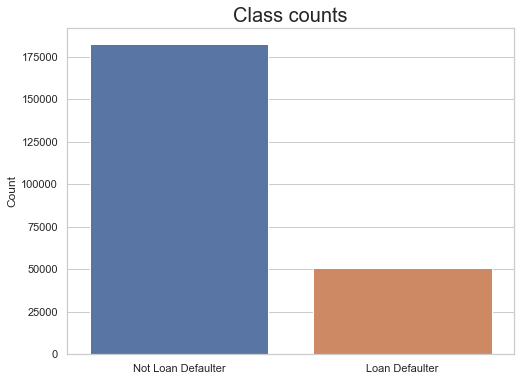

In [51]:
# Get number of positve and negative examples
pos = train[train["loan_default"] == 1].shape[0]
neg = train[train["loan_default"] == 0].shape[0]

print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")

plt.figure(figsize = (8, 6))
sns.countplot(train["loan_default"])
plt.xticks((0, 1), ["Not Loan Defaulter", "Loan Defaulter"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y = 1, fontdict = {"fontsize": 20});

In [52]:
train.employment_type.value_counts(dropna = False)

Self employed    127635
Salaried          97858
NaN                7661
Name: employment_type, dtype: int64

In [53]:
train[train["employment_type"].isna()].loan_default.value_counts(dropna = False)

0    6017
1    1644
Name: loan_default, dtype: int64

In [54]:
train["employment_type"].replace(np.NaN, "Self employed", inplace = True)

In [55]:
train.employment_type.value_counts(dropna = False)

Self employed    135296
Salaried          97858
Name: employment_type, dtype: int64

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
uniqueid                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
current_pincode_id                     233154 non-null int64
date_of_birth                          233154 non-null object
employment_type                        233154 non-null object
disbursaldate                          233154 non-null object
state_id                               233154 non-null int64
employee_code_id                       233154 non-null int64
mobileno_avl_flag                      233154 non-null int64
aadhar_flag                   

In [57]:
train['person_age_yrs'] = [x if x >= 0 else x+100 for x in (pd.to_datetime(train["disbursaldate"]).dt.year - 
                                                            pd.to_datetime(train["date_of_birth"]).dt.year)]

train.head(10)

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,person_age_yrs
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,34
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,33
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,33
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,25
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,41
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,Self employed,19-09-18,6,1998,1,1,0,0,0,0,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0,28
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,Salaried,23-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,30
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,Salaried,16-09-18,6,1998,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0,29
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-91,Self employed,05-09-18,6,1998,1,1,0,0,0,0,718,D-Very Low Risk,1,1,0,-41,365384,365384,0,0,0,0,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0,27
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-68,Salaried,16-09-18,6,1998,1,0,0,1,0,0,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0,50


In [58]:
def timeFeatures(df):
    # Derive new features using the click_time column
    df['datetime'] = pd.to_datetime(df['disbursaldate'], dayfirst = True)
    
    df['disbursal_day_of_week'] = df['datetime'].dt.dayofweek
    
    df["disbursal_day_of_year"] = df["datetime"].dt.dayofyear
    
    df["disbursal_month"] = df["datetime"].dt.month
    
    df.drop('datetime', axis = 1, inplace = True)
    
    return df

In [59]:
def age_split(df, column):
    
    str = df[column].str.split(" ", n = 1, expand = True)
    
    df[column] = [(int(x[0:-3])*12) + (int(y[0:-3])) for x, y in zip(str[0], str[1])]
    
    return df

In [60]:
def get_cns_score_description(df):
    
    df['perform_cns_score_description'] = [x[2:] if x[1] == "-" else x for x in df['perform_cns_score_description']]
    
    return df

In [61]:
def drop_columns(df):
    
    drop_list = ['uniqueid', 'date_of_birth', 'disbursaldate', 'branch_id', 'supplier_id', 
                 'current_pincode_id', 'employee_code_id', 'mobileno_avl_flag']
    
    df.drop(columns = drop_list, axis = 1, inplace = True)
    
    return df

In [62]:
train = timeFeatures(train)

train = age_split(train, 'average_acct_age')

train = age_split(train, 'credit_history_length')

train = get_cns_score_description(train)

train = drop_columns(train)

#train['mortgage_amount'] = (train['ltv'] * train['asset_cost'])/100

#train['total_acct_age_yrs'] = train['average_acct_age'] * train['pri_no_of_accts']

#train['self_paid_amount'] = train['asset_cost'] - train['disbursed_amount']

train.head(10)

,disbursed_amount,asset_cost,ltv,manufacturer_id,employment_type,state_id,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,person_age_yrs,disbursal_day_of_week,disbursal_day_of_year,disbursal_month
0,50578,58400,89.55,45,Salaried,6,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,4,215,8
1,47145,65550,73.23,45,Self employed,6,1,0,0,0,0,598,Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1,33,2,269,9
2,53278,61360,89.63,45,Self employed,6,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,2,213,8
3,57513,66113,88.48,45,Self employed,6,1,0,0,0,0,305,Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,8,15,1,1,25,4,299,10
4,52378,60300,88.39,45,Self employed,6,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,41,2,269,9
5,54513,61900,89.66,45,Self employed,6,1,0,0,0,0,825,Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,21,24,0,0,28,2,262,9
6,46349,61500,76.42,45,Salaried,6,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,6,266,9
7,43894,61900,71.89,45,Salaried,6,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,2,2,0,0,29,6,259,9
8,53713,61973,89.56,45,Self employed,6,1,0,0,0,0,718,Very Low Risk,1,1,0,-41,365384,365384,0,0,0,0,0,0,0,0,0,0,56,56,1,0,27,2,248,9
9,52603,61300,86.95,45,Salaried,6,0,0,1,0,0,818,Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,19,19,0,0,50,6,259,9


In [63]:
def get_unique_count(df, x):
    return len(df[x].unique())

In [64]:
{x: get_unique_count(train, x) for x in train.columns}

{'disbursed_amount': 24565,
 'asset_cost': 46252,
 'ltv': 6579,
 'manufacturer_id': 11,
 'employment_type': 2,
 'state_id': 22,
 'aadhar_flag': 2,
 'pan_flag': 2,
 'voterid_flag': 2,
 'driving_flag': 2,
 'passport_flag': 2,
 'perform_cns_score': 573,
 'perform_cns_score_description': 12,
 'pri_no_of_accts': 108,
 'pri_active_accts': 40,
 'pri_overdue_accts': 22,
 'pri_current_balance': 71341,
 'pri_sanctioned_amount': 44390,
 'pri_disbursed_amount': 47909,
 'sec_no_of_accts': 37,
 'sec_active_accts': 23,
 'sec_overdue_accts': 9,
 'sec_current_balance': 3246,
 'sec_sanctioned_amount': 2223,
 'sec_disbursed_amount': 2553,
 'primary_instal_amt': 28067,
 'sec_instal_amt': 1918,
 'new_accts_in_last_six_months': 26,
 'delinquent_accts_in_last_six_months': 14,
 'average_acct_age': 192,
 'credit_history_length': 294,
 'no_of_inquiries': 25,
 'loan_default': 2,
 'person_age_yrs': 48,
 'disbursal_day_of_week': 7,
 'disbursal_day_of_year': 84,
 'disbursal_month': 3}

In [65]:
def feature_engg(df, category_list):
    
    col_list = ['disbursed_amount', 'asset_cost', 'ltv', 'perform_cns_score', 'pri_no_of_accts', 'pri_active_accts', 
                'pri_overdue_accts', 'pri_current_balance', 'pri_sanctioned_amount', 'pri_disbursed_amount', 
                'primary_instal_amt', 'sec_instal_amt', 'new_accts_in_last_six_months', 
                'delinquent_accts_in_last_six_months', 'average_acct_age', 'credit_history_length', 'no_of_inquiries', 
                'person_age_yrs', 'disbursal_day_of_week', 'disbursal_day_of_year', 'disbursal_month']
    
    for column in category_list:
        
        for col in col_list:
            
            lv_count = df.groupby([column, col]).size().reset_index(name = (column + str("_") + col))
            
            df = pd.merge(df, lv_count, on = [column, col], how = 'left')
            
            del lv_count
            
    return df

In [66]:
category_list = ['manufacturer_id', 'employment_type', 'state_id', 'aadhar_flag', 'pan_flag', 'voterid_flag', 
                 'driving_flag', 'passport_flag', 'perform_cns_score_description']

train = feature_engg(train, category_list)

del category_list

train.head()

,disbursed_amount,asset_cost,ltv,manufacturer_id,employment_type,state_id,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,person_age_yrs,disbursal_day_of_week,disbursal_day_of_year,disbursal_month,manufacturer_id_disbursed_amount,manufacturer_id_asset_cost,manufacturer_id_ltv,manufacturer_id_perform_cns_score,manufacturer_id_pri_no_of_accts,manufacturer_id_pri_active_accts,manufacturer_id_pri_overdue_accts,manufacturer_id_pri_current_balance,manufacturer_id_pri_sanctioned_amount,manufacturer_id_pri_disbursed_amount,manufacturer_id_primary_instal_amt,manufacturer_id_sec_instal_amt,manufacturer_id_new_accts_in_last_six_months,manufacturer_id_delinquent_accts_in_last_six_months,manufacturer_id_average_acct_age,manufacturer_id_credit_history_length,manufacturer_id_no_of_inquiries,manufacturer_id_person_age_yrs,manufacturer_id_disbursal_day_of_week,manufacturer_id_disbursal_day_of_year,manufacturer_id_disbursal_month,employment_type_disbursed_amount,employment_type_asset_cost,employment_type_ltv,employment_type_perform_cns_score,employment_type_pri_no_of_accts,employment_type_pri_active_accts,employment_type_pri_overdue_accts,employment_type_pri_current_balance,employment_type_pri_sanctioned_amount,employment_type_pri_disbursed_amount,employment_type_primary_instal_amt,employment_type_sec_instal_amt,employment_type_new_accts_in_last_six_months,employment_type_delinquent_accts_in_last_six_months,employment_type_average_acct_age,employment_type_credit_history_length,employment_type_no_of_inquiries,employment_type_person_age_yrs,employment_type_disbursal_day_of_week,employment_type_disbursal_day_of_year,employment_type_disbursal_month,state_id_disbursed_amount,state_id_asset_cost,state_id_ltv,state_id_perform_cns_score,state_id_pri_no_of_accts,state_id_pri_active_accts,state_id_pri_overdue_accts,state_id_pri_current_balance,state_id_pri_sanctioned_amount,state_id_pri_disbursed_amount,state_id_primary_instal_amt,state_id_sec_instal_amt,state_id_new_accts_in_last_six_months,state_id_delinquent_accts_in_last_six_months,state_id_average_acct_age,state_id_credit_history_length,state_id_no_of_inquiries,state_id_person_age_yrs,state_id_disbursal_day_of_week,state_id_disbursal_day_of_year,state_id_disbursal_month,aadhar_flag_disbursed_amount,aadhar_flag_asset_cost,aadhar_flag_ltv,aadhar_flag_perform_cns_score,aadhar_flag_pri_no_of_accts,aadhar_flag_pri_active_accts,aadhar_flag_pri_overdue_accts,aadhar_flag_pri_current_balance,aadhar_flag_pri_sanctioned_amount,aadhar_flag_pri_disbursed_amount,aadhar_flag_primary_instal_amt,aadhar_flag_sec_instal_amt,aadhar_flag_new_accts_in_last_six_months,aadhar_flag_delinquent_accts_in_last_six_months,aadhar_flag_average_acct_age,aadhar_flag_credit_history_length,aadhar_flag_no_of_inquiries,aadhar_flag_person_age_yrs,aadhar_flag_disbursal_day_of_week,aadhar_flag_disbursal_day_of_year,aadhar_flag_disbursal_month,pan_flag_disbursed_amount,pan_flag_asset_cost,pan_flag_ltv,pan_flag_perform_cns_score,pan_flag_pri_no_of_accts,pan_flag_pri_active_accts,pan_flag_pri_overdue_accts,pan_flag_pri_current_balance,pan_flag_pri_sanctioned_amount,pan_flag_pri_disbursed_amount,pan_flag_primary_instal_amt,pan_flag_sec_instal_amt,pan_flag_new_accts_in_last_six_months,pan_flag_delinquent_accts_in_last_six_months,pan_flag_average_acct_age,pan_flag_credit_history_length,pan_flag_no_of_inquiries,pan_flag_person_age_yrs,pan_flag_disbursal_day_of_week,pan_flag_disbursal_day_of_year,pan_flag_disbursal_month,voterid_flag_disbursed_amount,voterid_flag_asset_cost,voterid_flag_ltv,voterid_f

In [67]:
def convert_dtypes(df):
    
    category_list = df.select_dtypes(include = [np.object]).columns
    
    exclude_list = ['disbursed_amount', 'asset_cost', 'ltv', 'pri_current_balance', 'pri_sanctioned_amount', 
                    'pri_disbursed_amount', 'sec_current_balance', 'sec_sanctioned_amount', 'sec_disbursed_amount', 
                    'employment_type', 'perform_cns_score_description']
    
    df[category_list] = df[category_list].astype('category')
    
    for column in df.columns:
        
        if column not in exclude_list:
            
            df[column] = df[column].astype('uint16')
    
    return df

In [68]:
train = convert_dtypes(train)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233154 entries, 0 to 233153
Columns: 226 entries, disbursed_amount to perform_cns_score_description_disbursal_month
dtypes: category(2), float64(1), int64(8), uint16(215)
memory usage: 113.8 MB


In [69]:
train.shape

(233154, 226)

In [70]:
test = pd.read_csv("test_bqCt9Pv.csv", skipinitialspace = True)

test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [71]:
test.shape

(112392, 40)

In [72]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Data columns (total 40 columns):
UniqueID                               112392 non-null int64
disbursed_amount                       112392 non-null int64
asset_cost                             112392 non-null int64
ltv                                    112392 non-null float64
branch_id                              112392 non-null int64
supplier_id                            112392 non-null int64
manufacturer_id                        112392 non-null int64
Current_pincode_ID                     112392 non-null int64
Date.of.Birth                          112392 non-null object
Employment.Type                        108949 non-null object
DisbursalDate                          112392 non-null object
State_ID                               112392 non-null int64
Employee_code_ID                       112392 non-null int64
MobileNo_Avl_Flag                      112392 non-null int64
Aadhar_flag                   

In [73]:
test.columns = test.columns.str.replace(".", "_")

test.columns = test.columns.str.lower()

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Data columns (total 40 columns):
uniqueid                               112392 non-null int64
disbursed_amount                       112392 non-null int64
asset_cost                             112392 non-null int64
ltv                                    112392 non-null float64
branch_id                              112392 non-null int64
supplier_id                            112392 non-null int64
manufacturer_id                        112392 non-null int64
current_pincode_id                     112392 non-null int64
date_of_birth                          112392 non-null object
employment_type                        108949 non-null object
disbursaldate                          112392 non-null object
state_id                               112392 non-null int64
employee_code_id                       112392 non-null int64
mobileno_avl_flag                      112392 non-null int64
aadhar_flag                   

In [74]:
test.employment_type.value_counts(dropna = False)

Self employed    59794
Salaried         49155
NaN               3443
Name: employment_type, dtype: int64

In [75]:
test["employment_type"].replace(np.NaN, "Self employed", inplace = True)

In [76]:
test.employment_type.value_counts(dropna = False)

Self employed    63237
Salaried         49155
Name: employment_type, dtype: int64

In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Data columns (total 40 columns):
uniqueid                               112392 non-null int64
disbursed_amount                       112392 non-null int64
asset_cost                             112392 non-null int64
ltv                                    112392 non-null float64
branch_id                              112392 non-null int64
supplier_id                            112392 non-null int64
manufacturer_id                        112392 non-null int64
current_pincode_id                     112392 non-null int64
date_of_birth                          112392 non-null object
employment_type                        112392 non-null object
disbursaldate                          112392 non-null object
state_id                               112392 non-null int64
employee_code_id                       112392 non-null int64
mobileno_avl_flag                      112392 non-null int64
aadhar_flag                   

In [78]:
test['person_age_yrs'] = [x if x >= 0 else x+100 for x in (pd.to_datetime(test["disbursaldate"]).dt.year - 
                                                    pd.to_datetime(test["date_of_birth"]).dt.year)]

test.head(10)

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,person_age_yrs
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,44
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1,33
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,23
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0,45
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,46
5,725530,57657,71211,84.64,78,17014,45,2103,01-01-68,Self employed,21-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,50
6,708592,48518,62767,82.85,78,17014,45,2071,06-09-82,Salaried,17-11-18,4,1646,1,1,0,0,0,0,383,K-High Risk,5,4,2,336355,333290,333290,0,0,0,0,0,0,2122,0,0,0,1yrs 7mon,2yrs 5mon,0,36
7,714975,48743,63896,81.38,78,17014,45,2079,24-11-95,Salaried,19-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,23
8,712795,50295,63896,82.35,78,17014,45,2071,01-01-88,Salaried,18-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,30
9,708656,51653,67445,81.55,78,17014,45,2078,01-01-99,Self employed,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,19


In [79]:
test = timeFeatures(test)

test = age_split(test, 'average_acct_age')

test = age_split(test, 'credit_history_length')

test = get_cns_score_description(test)

y_predicted_uniqueid = test['uniqueid']

test = drop_columns(test)

#test['mortgage_amount'] = (test['ltv'] * test['asset_cost'])/100

#test['total_acct_age_yrs'] = test['average_acct_age'] * test['pri_no_of_accts']

#test['self_paid_amount'] = test['asset_cost'] - test['disbursed_amount']

test.head(10)

,disbursed_amount,asset_cost,ltv,manufacturer_id,employment_type,state_id,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,person_age_yrs,disbursal_day_of_week,disbursal_day_of_year,disbursal_month
0,53478,63558,86.54,45,Salaried,6,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,5,307,11
1,55513,63163,89.45,45,Self employed,6,1,0,0,0,0,749,Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,8,12,1,33,1,324,11
2,65282,84320,79.93,86,Salaried,4,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,3,333,11
3,46905,63896,76.58,45,Self employed,4,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,29,29,0,45,3,333,11
4,51428,63896,86.08,45,Salaried,4,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,5,321,11
5,57657,71211,84.64,45,Self employed,4,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50,2,325,11
6,48518,62767,82.85,45,Salaried,4,1,0,0,0,0,383,High Risk,5,4,2,336355,333290,333290,0,0,0,0,0,0,2122,0,0,0,19,29,0,36,5,321,11
7,48743,63896,81.38,45,Salaried,4,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,323,11
8,50295,63896,82.35,45,Salaried,4,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,6,322,11
9,51653,67445,81.55,45,Self employed,4,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,5,321,11


In [80]:
y_predicted_uniqueid.head()

0    655269
1    723482
2    758529
3    763449
4    708663
Name: uniqueid, dtype: int64

In [81]:
{x: get_unique_count(test, x) for x in test.columns}

{'disbursed_amount': 14525,
 'asset_cost': 29383,
 'ltv': 5902,
 'manufacturer_id': 11,
 'employment_type': 2,
 'state_id': 22,
 'aadhar_flag': 2,
 'pan_flag': 2,
 'voterid_flag': 2,
 'driving_flag': 2,
 'passport_flag': 2,
 'perform_cns_score': 566,
 'perform_cns_score_description': 11,
 'pri_no_of_accts': 83,
 'pri_active_accts': 32,
 'pri_overdue_accts': 16,
 'pri_current_balance': 35550,
 'pri_sanctioned_amount': 21721,
 'pri_disbursed_amount': 23343,
 'sec_no_of_accts': 23,
 'sec_active_accts': 15,
 'sec_overdue_accts': 7,
 'sec_current_balance': 742,
 'sec_sanctioned_amount': 610,
 'sec_disbursed_amount': 663,
 'primary_instal_amt': 17125,
 'sec_instal_amt': 470,
 'new_accts_in_last_six_months': 20,
 'delinquent_accts_in_last_six_months': 13,
 'average_acct_age': 176,
 'credit_history_length': 252,
 'no_of_inquiries': 22,
 'person_age_yrs': 47,
 'disbursal_day_of_week': 7,
 'disbursal_day_of_year': 27,
 'disbursal_month': 1}

In [82]:
category_list = ['manufacturer_id', 'employment_type', 'state_id', 'aadhar_flag', 'pan_flag', 'voterid_flag', 
                 'driving_flag', 'passport_flag', 'perform_cns_score_description']

test = feature_engg(test, category_list)

del category_list

test.head()

,disbursed_amount,asset_cost,ltv,manufacturer_id,employment_type,state_id,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,person_age_yrs,disbursal_day_of_week,disbursal_day_of_year,disbursal_month,manufacturer_id_disbursed_amount,manufacturer_id_asset_cost,manufacturer_id_ltv,manufacturer_id_perform_cns_score,manufacturer_id_pri_no_of_accts,manufacturer_id_pri_active_accts,manufacturer_id_pri_overdue_accts,manufacturer_id_pri_current_balance,manufacturer_id_pri_sanctioned_amount,manufacturer_id_pri_disbursed_amount,manufacturer_id_primary_instal_amt,manufacturer_id_sec_instal_amt,manufacturer_id_new_accts_in_last_six_months,manufacturer_id_delinquent_accts_in_last_six_months,manufacturer_id_average_acct_age,manufacturer_id_credit_history_length,manufacturer_id_no_of_inquiries,manufacturer_id_person_age_yrs,manufacturer_id_disbursal_day_of_week,manufacturer_id_disbursal_day_of_year,manufacturer_id_disbursal_month,employment_type_disbursed_amount,employment_type_asset_cost,employment_type_ltv,employment_type_perform_cns_score,employment_type_pri_no_of_accts,employment_type_pri_active_accts,employment_type_pri_overdue_accts,employment_type_pri_current_balance,employment_type_pri_sanctioned_amount,employment_type_pri_disbursed_amount,employment_type_primary_instal_amt,employment_type_sec_instal_amt,employment_type_new_accts_in_last_six_months,employment_type_delinquent_accts_in_last_six_months,employment_type_average_acct_age,employment_type_credit_history_length,employment_type_no_of_inquiries,employment_type_person_age_yrs,employment_type_disbursal_day_of_week,employment_type_disbursal_day_of_year,employment_type_disbursal_month,state_id_disbursed_amount,state_id_asset_cost,state_id_ltv,state_id_perform_cns_score,state_id_pri_no_of_accts,state_id_pri_active_accts,state_id_pri_overdue_accts,state_id_pri_current_balance,state_id_pri_sanctioned_amount,state_id_pri_disbursed_amount,state_id_primary_instal_amt,state_id_sec_instal_amt,state_id_new_accts_in_last_six_months,state_id_delinquent_accts_in_last_six_months,state_id_average_acct_age,state_id_credit_history_length,state_id_no_of_inquiries,state_id_person_age_yrs,state_id_disbursal_day_of_week,state_id_disbursal_day_of_year,state_id_disbursal_month,aadhar_flag_disbursed_amount,aadhar_flag_asset_cost,aadhar_flag_ltv,aadhar_flag_perform_cns_score,aadhar_flag_pri_no_of_accts,aadhar_flag_pri_active_accts,aadhar_flag_pri_overdue_accts,aadhar_flag_pri_current_balance,aadhar_flag_pri_sanctioned_amount,aadhar_flag_pri_disbursed_amount,aadhar_flag_primary_instal_amt,aadhar_flag_sec_instal_amt,aadhar_flag_new_accts_in_last_six_months,aadhar_flag_delinquent_accts_in_last_six_months,aadhar_flag_average_acct_age,aadhar_flag_credit_history_length,aadhar_flag_no_of_inquiries,aadhar_flag_person_age_yrs,aadhar_flag_disbursal_day_of_week,aadhar_flag_disbursal_day_of_year,aadhar_flag_disbursal_month,pan_flag_disbursed_amount,pan_flag_asset_cost,pan_flag_ltv,pan_flag_perform_cns_score,pan_flag_pri_no_of_accts,pan_flag_pri_active_accts,pan_flag_pri_overdue_accts,pan_flag_pri_current_balance,pan_flag_pri_sanctioned_amount,pan_flag_pri_disbursed_amount,pan_flag_primary_instal_amt,pan_flag_sec_instal_amt,pan_flag_new_accts_in_last_six_months,pan_flag_delinquent_accts_in_last_six_months,pan_flag_average_acct_age,pan_flag_credit_history_length,pan_flag_no_of_inquiries,pan_flag_person_age_yrs,pan_flag_disbursal_day_of_week,pan_flag_disbursal_day_of_year,pan_flag_disbursal_month,voterid_flag_disbursed_amount,voterid_flag_asset_cost,voterid_flag_ltv,voterid_flag_perform_c

In [83]:
test = convert_dtypes(test)

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112392 entries, 0 to 112391
Columns: 225 entries, disbursed_amount to perform_cns_score_description_disbursal_month
dtypes: category(2), float64(1), int64(8), uint16(214)
memory usage: 54.7 MB


In [84]:
test.shape

(112392, 225)

In [86]:
# apply Label encoder
le = LabelEncoder()

train['employment_type'] = le.fit_transform(train['employment_type'])
test['employment_type'] = le.transform(test['employment_type'])
train['employment_type'] = train['employment_type'].astype('uint8')
test['employment_type'] = test['employment_type'].astype('uint8')

train['perform_cns_score_description'] = le.fit_transform(train['perform_cns_score_description'])
test['perform_cns_score_description'] = le.transform(test['perform_cns_score_description'])
train['perform_cns_score_description'] = train['perform_cns_score_description'].astype('uint8')
test['perform_cns_score_description'] = test['perform_cns_score_description'].astype('uint8')

In [ ]:
# col = ['person_age_yrs_range', 'ltv_range', 'cns_score_range']

# status = pd.get_dummies(train[col])

# train = pd.concat([train, status], axis = 1)

# drop_list = ['person_age_yrs_range_0-20', 'ltv_range_0-10', 'cns_score_range_0-299']

# train.drop(columns = drop_list, axis = 1, inplace = True)

# test = pd.concat([test, status], axis = 1)

# drop_list = ['person_age_yrs_range_0-20', 'ltv_range_0-10', 'cns_score_range_0-299']

# test.drop(columns = drop_list, axis = 1, inplace = True)

In [88]:
train.head()

,disbursed_amount,asset_cost,ltv,manufacturer_id,employment_type,state_id,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,person_age_yrs,disbursal_day_of_week,disbursal_day_of_year,disbursal_month,manufacturer_id_disbursed_amount,manufacturer_id_asset_cost,manufacturer_id_ltv,manufacturer_id_perform_cns_score,manufacturer_id_pri_no_of_accts,manufacturer_id_pri_active_accts,manufacturer_id_pri_overdue_accts,manufacturer_id_pri_current_balance,manufacturer_id_pri_sanctioned_amount,manufacturer_id_pri_disbursed_amount,manufacturer_id_primary_instal_amt,manufacturer_id_sec_instal_amt,manufacturer_id_new_accts_in_last_six_months,manufacturer_id_delinquent_accts_in_last_six_months,manufacturer_id_average_acct_age,manufacturer_id_credit_history_length,manufacturer_id_no_of_inquiries,manufacturer_id_person_age_yrs,manufacturer_id_disbursal_day_of_week,manufacturer_id_disbursal_day_of_year,manufacturer_id_disbursal_month,employment_type_disbursed_amount,employment_type_asset_cost,employment_type_ltv,employment_type_perform_cns_score,employment_type_pri_no_of_accts,employment_type_pri_active_accts,employment_type_pri_overdue_accts,employment_type_pri_current_balance,employment_type_pri_sanctioned_amount,employment_type_pri_disbursed_amount,employment_type_primary_instal_amt,employment_type_sec_instal_amt,employment_type_new_accts_in_last_six_months,employment_type_delinquent_accts_in_last_six_months,employment_type_average_acct_age,employment_type_credit_history_length,employment_type_no_of_inquiries,employment_type_person_age_yrs,employment_type_disbursal_day_of_week,employment_type_disbursal_day_of_year,employment_type_disbursal_month,state_id_disbursed_amount,state_id_asset_cost,state_id_ltv,state_id_perform_cns_score,state_id_pri_no_of_accts,state_id_pri_active_accts,state_id_pri_overdue_accts,state_id_pri_current_balance,state_id_pri_sanctioned_amount,state_id_pri_disbursed_amount,state_id_primary_instal_amt,state_id_sec_instal_amt,state_id_new_accts_in_last_six_months,state_id_delinquent_accts_in_last_six_months,state_id_average_acct_age,state_id_credit_history_length,state_id_no_of_inquiries,state_id_person_age_yrs,state_id_disbursal_day_of_week,state_id_disbursal_day_of_year,state_id_disbursal_month,aadhar_flag_disbursed_amount,aadhar_flag_asset_cost,aadhar_flag_ltv,aadhar_flag_perform_cns_score,aadhar_flag_pri_no_of_accts,aadhar_flag_pri_active_accts,aadhar_flag_pri_overdue_accts,aadhar_flag_pri_current_balance,aadhar_flag_pri_sanctioned_amount,aadhar_flag_pri_disbursed_amount,aadhar_flag_primary_instal_amt,aadhar_flag_sec_instal_amt,aadhar_flag_new_accts_in_last_six_months,aadhar_flag_delinquent_accts_in_last_six_months,aadhar_flag_average_acct_age,aadhar_flag_credit_history_length,aadhar_flag_no_of_inquiries,aadhar_flag_person_age_yrs,aadhar_flag_disbursal_day_of_week,aadhar_flag_disbursal_day_of_year,aadhar_flag_disbursal_month,pan_flag_disbursed_amount,pan_flag_asset_cost,pan_flag_ltv,pan_flag_perform_cns_score,pan_flag_pri_no_of_accts,pan_flag_pri_active_accts,pan_flag_pri_overdue_accts,pan_flag_pri_current_balance,pan_flag_pri_sanctioned_amount,pan_flag_pri_disbursed_amount,pan_flag_primary_instal_amt,pan_flag_sec_instal_amt,pan_flag_new_accts_in_last_six_months,pan_flag_delinquent_accts_in_last_six_months,pan_flag_average_acct_age,pan_flag_credit_history_length,pan_flag_no_of_inquiries,pan_flag_person_age_yrs,pan_flag_disbursal_day_of_week,pan_flag_disbursal_day_of_year,pan_flag_disbursal_month,voterid_flag_disbursed_amount,voterid_flag_asset_cost,voterid_flag_ltv,voterid_f

In [89]:
test.head()

,disbursed_amount,asset_cost,ltv,manufacturer_id,employment_type,state_id,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,person_age_yrs,disbursal_day_of_week,disbursal_day_of_year,disbursal_month,manufacturer_id_disbursed_amount,manufacturer_id_asset_cost,manufacturer_id_ltv,manufacturer_id_perform_cns_score,manufacturer_id_pri_no_of_accts,manufacturer_id_pri_active_accts,manufacturer_id_pri_overdue_accts,manufacturer_id_pri_current_balance,manufacturer_id_pri_sanctioned_amount,manufacturer_id_pri_disbursed_amount,manufacturer_id_primary_instal_amt,manufacturer_id_sec_instal_amt,manufacturer_id_new_accts_in_last_six_months,manufacturer_id_delinquent_accts_in_last_six_months,manufacturer_id_average_acct_age,manufacturer_id_credit_history_length,manufacturer_id_no_of_inquiries,manufacturer_id_person_age_yrs,manufacturer_id_disbursal_day_of_week,manufacturer_id_disbursal_day_of_year,manufacturer_id_disbursal_month,employment_type_disbursed_amount,employment_type_asset_cost,employment_type_ltv,employment_type_perform_cns_score,employment_type_pri_no_of_accts,employment_type_pri_active_accts,employment_type_pri_overdue_accts,employment_type_pri_current_balance,employment_type_pri_sanctioned_amount,employment_type_pri_disbursed_amount,employment_type_primary_instal_amt,employment_type_sec_instal_amt,employment_type_new_accts_in_last_six_months,employment_type_delinquent_accts_in_last_six_months,employment_type_average_acct_age,employment_type_credit_history_length,employment_type_no_of_inquiries,employment_type_person_age_yrs,employment_type_disbursal_day_of_week,employment_type_disbursal_day_of_year,employment_type_disbursal_month,state_id_disbursed_amount,state_id_asset_cost,state_id_ltv,state_id_perform_cns_score,state_id_pri_no_of_accts,state_id_pri_active_accts,state_id_pri_overdue_accts,state_id_pri_current_balance,state_id_pri_sanctioned_amount,state_id_pri_disbursed_amount,state_id_primary_instal_amt,state_id_sec_instal_amt,state_id_new_accts_in_last_six_months,state_id_delinquent_accts_in_last_six_months,state_id_average_acct_age,state_id_credit_history_length,state_id_no_of_inquiries,state_id_person_age_yrs,state_id_disbursal_day_of_week,state_id_disbursal_day_of_year,state_id_disbursal_month,aadhar_flag_disbursed_amount,aadhar_flag_asset_cost,aadhar_flag_ltv,aadhar_flag_perform_cns_score,aadhar_flag_pri_no_of_accts,aadhar_flag_pri_active_accts,aadhar_flag_pri_overdue_accts,aadhar_flag_pri_current_balance,aadhar_flag_pri_sanctioned_amount,aadhar_flag_pri_disbursed_amount,aadhar_flag_primary_instal_amt,aadhar_flag_sec_instal_amt,aadhar_flag_new_accts_in_last_six_months,aadhar_flag_delinquent_accts_in_last_six_months,aadhar_flag_average_acct_age,aadhar_flag_credit_history_length,aadhar_flag_no_of_inquiries,aadhar_flag_person_age_yrs,aadhar_flag_disbursal_day_of_week,aadhar_flag_disbursal_day_of_year,aadhar_flag_disbursal_month,pan_flag_disbursed_amount,pan_flag_asset_cost,pan_flag_ltv,pan_flag_perform_cns_score,pan_flag_pri_no_of_accts,pan_flag_pri_active_accts,pan_flag_pri_overdue_accts,pan_flag_pri_current_balance,pan_flag_pri_sanctioned_amount,pan_flag_pri_disbursed_amount,pan_flag_primary_instal_amt,pan_flag_sec_instal_amt,pan_flag_new_accts_in_last_six_months,pan_flag_delinquent_accts_in_last_six_months,pan_flag_average_acct_age,pan_flag_credit_history_length,pan_flag_no_of_inquiries,pan_flag_person_age_yrs,pan_flag_disbursal_day_of_week,pan_flag_disbursal_day_of_year,pan_flag_disbursal_month,voterid_flag_disbursed_amount,voterid_flag_asset_cost,voterid_flag_ltv,voterid_flag_perform_c

In [90]:
train.shape

(233154, 226)

In [91]:
test.shape

(112392, 225)

In [92]:
# garbage collect (unused) object
gc.collect()

319

In [93]:
# create x and y train
'''x_labels = {'uniqueid', 'ltv', 'branch_id', 'supplier_id', 'manufacturer_id', 'current_pincode_id', 
            'date_of_birth', 'disbursaldate', 'state_id', 'employee_code_id', 'mobileno_avl_flag', 
            'aadhar_flag', 'pan_flag', 'voterid_flag', 'driving_flag', 'passport_flag', 'perform_cns_score', 
            'perform_cns_score_description', 'person_age_yrs', 'person_age_yrs_range', 'cns_score_range', 
            'ltv_range', 'loan_default'}

x_predicted_labels = {'uniqueid', 'ltv', 'branch_id', 'supplier_id', 'manufacturer_id', 'current_pincode_id', 
            'date_of_birth', 'disbursaldate', 'state_id', 'employee_code_id', 'mobileno_avl_flag', 
            'aadhar_flag', 'pan_flag', 'voterid_flag', 'driving_flag', 'passport_flag', 'perform_cns_score', 
            'perform_cns_score_description', 'person_age_yrs', 'person_age_yrs_range', 'cns_score_range', 
            'ltv_range'}'''

'''x_labels = {'uniqueid', 'ltv', 'date_of_birth', 'disbursaldate', 'mobileno_avl_flag', 'loan_default', 
            'perform_cns_score_description', 'average_acct_age', 'credit_history_length'}

x_predicted_labels = {'uniqueid', 'ltv', 'date_of_birth', 'disbursaldate', 'mobileno_avl_flag', 
                      'perform_cns_score_description', 'average_acct_age', 'credit_history_length'}'''

'''X = train.drop(labels = x_labels, axis = 1)
y = train[['loan_default']]
X_predicted = test.drop(labels = x_predicted_labels, axis = 1)

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 100)'''

X = train.drop('loan_default', axis = 1)
y = train[['loan_default']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 100)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#print(X_predicted.shape)

(174865, 225)
(174865, 1)
(58289, 225)
(58289, 1)


### Imbalanced Datasets

In [94]:
# Standardize the data
std = RobustScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)
X_predicted = std.transform(test)

# Implement RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)

# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]

In [95]:
# Define base learners

xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=750,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123
                           )
'''svm_clf = SVC(gamma = 0.1,
              C = 0.01,
              kernel = "poly",
              degree = 3,
              coef0 = 10.0,
              probability = True)'''

rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced"
                               )

# Define meta-learner
logreg_clf = LogisticRegression(penalty = "l2", C = 100, fit_intercept=True, n_jobs = 16)

# Fitting voting clf --> average ensemble
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               #("svm", svm_clf),
                               ("rf", rf_clf)
                              ],
                              voting = "soft",
                              flatten_transform = True
                             )
voting_clf.fit(X_res, y_res)
#xgb_model, svm_model, rf_model = voting_clf.estimators_
xgb_model, rf_model = voting_clf.estimators_

models = {"xgb": xgb_model,
          #"svm": svm_model,
          "rf": rf_model,
          "avg_ensemble": voting_clf}

# Build first stack of base learners
first_stack = make_pipeline(voting_clf, FunctionTransformer(lambda X: X[:, 1::2]))

# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack, X_res, y_res, cv = 5, method="transform", n_jobs = 16)

# Refit the first stack on the full training set
first_stack.fit(X_res, y_res)

# Fit the meta learner
second_stack = logreg_clf.fit(meta_features, y_res)

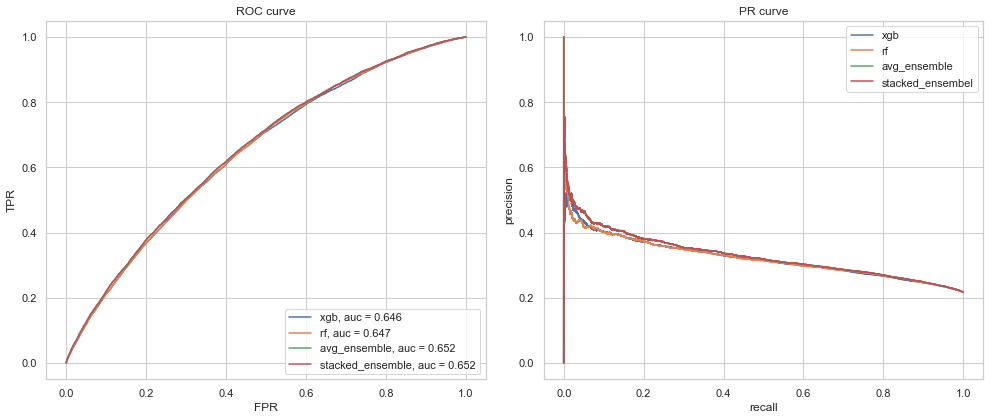

In [96]:
# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
  model_probs = model.predict_proba(X_test)[:, 1:]
  model_auc_score = metrics.roc_auc_score(y_test, model_probs)
  fpr, tpr, _ = metrics.roc_curve(y_test, model_probs)
  precision, recall, _ = metrics.precision_recall_curve(y_test, model_probs)
  axes[0].plot(fpr, tpr, label = f"{name}, auc = {model_auc_score:.3f}")
  axes[1].plot(recall, precision, label = f"{name}")

stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = metrics.roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = metrics.roc_curve(y_test, stacked_probs)
precision, recall, _ = metrics.precision_recall_curve(y_test, stacked_probs)

axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembel")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

In [97]:
y_stacked_pred = second_stack.predict(first_stack.transform(X_predicted))

In [98]:
# Write the columns 'id' and 'predictions' into the output file
sub = pd.DataFrame({'UniqueID': y_predicted_uniqueid, 'loan_default': y_stacked_pred})

sub = sub.reindex(columns=["UniqueID", "loan_default"])

filename = 'submission_18.csv'

sub.to_csv(filename, index = False, sep = ",")